In [70]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn_pandas import DataFrameMapper
    from sklearn import metrics
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
    from sklearn.decomposition import PCA
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import mean_squared_error
    from sklearn.linear_model import LinearRegression, Lasso, Ridge
    import warnings
    print("Se importó correctamente")
except Exception as e:
    print(f"Error al importar dependencias: {e}")

Se importó correctamente


* Al tener el Data Set repartido en 4 archivos diferentes segun la plataforma donde se produjeron las ventas, paso a unificar todo en un mismo DataFrame

In [2]:
import pandas as pd
import os

# Ruta a la carpeta que contiene los archivos
ruta_carpeta = "./csv"

# Lista de archivos que deseas concatenar
archivos_csv = ["fravega.csv", "ecommerce.csv", "mercadolibre.csv", "megatone.csv"]

# Leer los archivos con el delimitador adecuado y almacenarlos en una lista de DataFrames
dfs = [pd.read_csv(os.path.join(ruta_carpeta, archivo), encoding='latin1', delimiter=';') for archivo in archivos_csv]

# Concatenar los DataFrames en uno solo
sales = pd.concat(dfs, ignore_index=True)

sales.sample(5)

,VALOR PRED.,ORDEN DE RETIRO,FECHA RETIRO OCA,COD. PRODUCTO,CANTIDAD,PRODUCTO,DTO %,FECHA COMPRA,PROVINCIA,LOCALIDAD,PLATAFORMA
3939,1.0,NaN,9/11/2022,1-23-15-004,1.0,NaN,NaN,3/11/2022,LA PAMPA,General pico,mercadolibre
3763,1.0,NaN,4/11/2022,1-15-36-002,1.0,NaN,NaN,31/10/2022,BUENOS AIRES,San Nicolás de Los Arroyos,mercadolibre
7940,1,95968219,4/3/2022,1-11-08-002,1.0,COLCHÓN L. PEKIN TRADICIONAL 80CMX190CM,0,24/2/2022,CÓRDOBA,CORDOBA,megatone
10659,1,106699906,NaN,NaN,1.0,CONJUNTO L. GRANATE TRADICIONAL 180CMX200CM,4,11/5/2023,SANTA FE,MALABRIGO,megatone
6772,1.0,NaN,5/10/2023,1-15-37-018,1.0,CONJUNTO L. VASARI TRADICIONAL 180CMX200CM,NaN,3/10/2023,BUENOS AIRES,Olavarría,mercadolibre


## Listado de variables 

#### Variables de entrada

* VALOR PRED.: Representa el valor del bulto.
* ORDEN DE RETIRO: Nro de orden por la cual la empresa identifica cada venta
* FECHA RETIRO OCA: Fecha donde OCA retira el producto
* COD. PRODUCTO: Identificador único de cada producto.
* PRODUCTO: Descripción del producto
* DTO %: Descuento aplicado en cada venta.
* FECHA COMPRA: Fecha en la que se realizó la compra del producto
* PROVINCIA: Nombre de la provincia donde se produjo de la venta
* LOCALIDAD: Nombre de la localidad donde se produjo de la venta
* PLATAFORMA: Canal o medio donde se produjo la venta.

#### Variable de salida: 

* CANTIDAD: representa el número de unidades vendidas por producto

#### Reorganizo las columnas en el orden deseado

In [3]:
orden_columnas = [
    'VALOR PRED.', 'ORDEN DE RETIRO', 'FECHA COMPRA', 'FECHA RETIRO OCA','COD. PRODUCTO', 'PRODUCTO', 'DTO %', 'PROVINCIA', 'LOCALIDAD', 'PLATAFORMA',
    'CANTIDAD'
]

# Reorganizar el DataFrame
sales = sales[orden_columnas]

# Mostrar las primeras filas del DataFrame reorganizado
print("Columnas reorganizadas:")
sales.sample(5)

Columnas reorganizadas:


,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
8360,1,98112254,31/5/2022,6/6/2022,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,3,BUENOS AIRES,BARRIO NUEVO,megatone,1.0
10365,1,106764898,13/5/2023,NaN,NaN,COLCHÓN L. PEKIN TRADICIONAL 80CMX190CM,4,MISIONES,CAMPO GRANDE,megatone,1.0
4540,1.0,NaN,30/1/2023,2/2/2023,1-23-15-004,PROMO 2 CONJUNTOS L. DALI TRADICIONAL 80CMX190CM,NaN,CHUBUT,Puerto Madryn,mercadolibre,1.0
4420,1.0,NaN,4/1/2023,4/1/2023,1-23-04-002,COMBO X2 ALM. VELLÓN 70,NaN,CAPITAL FEDERAL,Monte Castro,mercadolibre,1.0
1096,1,90863065,18/7/2021,22/7/2021,NaN,CONJUNTO L. DALI TRADICIONAL 80CMX190CM,"$ 0,00",NEUQUÉN,Cutral co,ecommerce,1


## Análisis detallado de un conjunto de variables

La variable CANTIDAD representa el número de unidades vendidas. Es la variable objetivo de este análisis, ya que el modelo buscará predecir su valor en función de las características del dataset.

Predecir CANTIDAD permitirá:

* Identificar tendencias de venta.
* Optimizar la planificación de inventarios.
* Mejorar la estrategia de ventas y promociones.

### Estadísticas descriptivas de la variable de salida

In [4]:
print("Estadísticas descriptivas de 'CANTIDAD':")
print(sales['CANTIDAD'].describe())

Estadísticas descriptivas de 'CANTIDAD':
count     11103
unique       15
top           1
freq       8976
Name: CANTIDAD, dtype: int64


In [5]:
# Convierto la columna 'CANTIDAD' a numérico, convirtiendo valores no válidos a NaN
sales['CANTIDAD'] = pd.to_numeric(sales['CANTIDAD'], errors='coerce')
# Reemplazo los valores NaN con 1
sales['CANTIDAD'] = sales['CANTIDAD'].fillna(1)
# Convierto la columna a enteros
sales['CANTIDAD'] = sales['CANTIDAD'].astype(int)

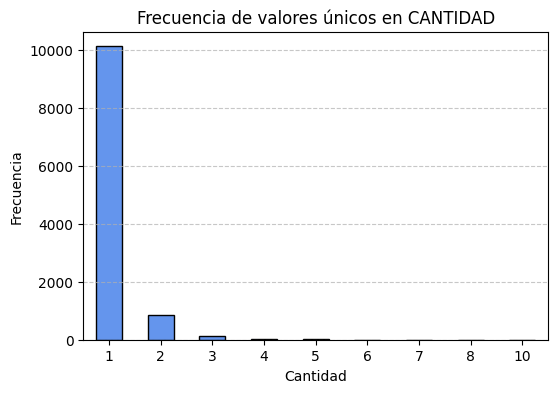

In [6]:
# Frecuencia de valores únicos en 'CANTIDAD'
frecuencia_cantidad = sales['CANTIDAD'].value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(6, 4))
frecuencia_cantidad.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title('Frecuencia de valores únicos en CANTIDAD', fontsize=12)
plt.xlabel('Cantidad', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



## EDA, Limpieza y preprocesamiento

* Verificación de valores nulos en variable COD PRODUCTO y PRODUCTO:

In [7]:
# Contar nulos y valores vacíos en 'COD. PRODUCTO'
nulos_o_vacios_cod_producto = sales['COD. PRODUCTO'].isna().sum() + sales['COD. PRODUCTO'].eq('').sum()

# Contar nulos y valores vacíos en 'PRODUCTO'
nulos_o_vacios_producto = sales['PRODUCTO'].isna().sum() + sales['PRODUCTO'].str.strip().eq('').sum()

print(f"Valores nulos o vacíos en 'COD. PRODUCTO': {nulos_o_vacios_cod_producto}")
print(f"Valores nulos o vacíos en 'PRODUCTO': {nulos_o_vacios_producto}")

Valores nulos o vacíos en 'COD. PRODUCTO': 3298
Valores nulos o vacíos en 'PRODUCTO': 2198


- Tratamiento para determinar que para algunos de los COD PRODUCTOS detectados sin descripcion de Producto tenga en algun otro lado del data set la descripcion. Lo mismo para aquellas Productos detectados sin Cod Producto. 
El objetivo de esto es rellenar valores que se detectan nulos en las columnas de COD PRODUCTO y PRODUCTO.

In [8]:
# Crear un mapeo único entre COD PRODUCTO y PRODUCTO
mapeo_cod_producto = sales[['COD. PRODUCTO', 'PRODUCTO']].drop_duplicates()

print("Mapa único entre códigos y productos:")
mapeo_cod_producto.shape

Mapa único entre códigos y productos:


(478, 2)

In [9]:
# Convertir el mapeo a un diccionario para facilitar su uso
mapeo_dict = mapeo_cod_producto.set_index('PRODUCTO')['COD. PRODUCTO'].to_dict()

# Completar o corregir la columna 'COD PRODUCTO'
sales['COD. PRODUCTO'] = sales['PRODUCTO'].map(mapeo_dict)

In [10]:
# Detectar inconsistencias entre 'COD PRODUCTO' y 'PRODUCTO'
inconsistencias = sales[sales['PRODUCTO'] != sales['COD. PRODUCTO'].map(mapeo_dict)]

In [11]:
sales['PRODUCTO'] = sales['COD. PRODUCTO'].map({v: k for k, v in mapeo_dict.items()})


In [12]:
sales.sample(5)

,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
8387,1,98145452,1/6/2022,8/6/2022,1-12-40-003,COLCHÓN L. ROMA TRADICIONAL 90CMX190CM,3,TUCUMÁN,TAFI VIEJO,megatone,1
736,1,NaN,30/9/2023,5/10/2023,NaN,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0,MENDOZA,Ugarteche,fravega,1
6813,1.0,NaN,14/10/2023,27/10/2023,NaN,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,NEUQUÉN,Centenario,mercadolibre,1
4067,1.0,NaN,16/11/2022,18//11/2022,1-11-16-017,NaN,NaN,RÍO NEGRO,Bariloche,mercadolibre,1
1729,1,93433090,3/11/2021,6/11/2021,NaN,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,CÓRDOBA,CORDOBA,ecommerce,1


In [13]:
faltantes_codproducto = sales[sales['COD. PRODUCTO'].isna()]
# Obtener los valores únicos de la columna 'PRODUCTO'
valores_unicos_producto = faltantes_codproducto['PRODUCTO'].unique()

print(valores_unicos_producto)

['CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM']


In [14]:
productos_con_nan = sales[sales['COD. PRODUCTO'].isna()]

# Mostrar valores únicos de la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN
valores_producto_nan = productos_con_nan['PRODUCTO'].unique()

print("Valores únicos en la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN:")
print(valores_producto_nan)

Valores únicos en la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN:
['CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM']


In [15]:
sales.loc[sales['COD. PRODUCTO'].isna(), 'COD. PRODUCTO'] = '1-20-20-200'

In [16]:
sales.sample(2)

,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
5842,1.0,106687223,10/5/2023,19/5/2023,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,CÓRDOBA,Bell Ville,mercadolibre,1
2616,1.0,98144325,31/5/2022,2/6/2022,1-11-16-017,NaN,15.0,ENTRE RÍOS,Villa Paranacito,mercadolibre,1


* Verificamos si quedan filas donde 'COD PRODUCTO' es nulo

In [17]:
sin_codproducto = sales[sales['COD. PRODUCTO'].isna()]
print("Filas con 'COD PRODUCTO' faltante:")
sin_codproducto.shape

Filas con 'COD PRODUCTO' faltante:


(0, 11)

In [18]:
# Mostrar filas donde 'PRODUCTO' es NaN
sin_producto = sales[sales['PRODUCTO'].isna()]
print("Filas con 'PRODUCTO' faltante:")
sin_producto.shape

Filas con 'PRODUCTO' faltante:


(2212, 11)

In [19]:
# Contar valores únicos en 'COD. PRODUCTO'
valores_unicos_cod_producto = sin_producto['COD. PRODUCTO'].unique()

# Contar la cantidad de valores únicos
cantidad_valores_unicos = len(valores_unicos_cod_producto)
print(valores_unicos_cod_producto)

['1-11-16-017']


In [20]:
sales.loc[sales['PRODUCTO'].isna() , 'PRODUCTO'] = 'Descripcion de producto pendiente a consultar al cliente'

In [21]:
# Contar valores nulos en cada columna
valores_nulos = sales.isna().sum()

print("Cantidad de valores nulos por columna:")
print(valores_nulos)

Cantidad de valores nulos por columna:
VALOR PRED.          254
ORDEN DE RETIRO     3852
FECHA COMPRA          40
FECHA RETIRO OCA    1104
COD. PRODUCTO          0
PRODUCTO               0
DTO %               6457
PROVINCIA             57
LOCALIDAD            247
PLATAFORMA             0
CANTIDAD               0
dtype: int64


* Limpieza y correccion de valores en las columnas. 

In [22]:
# Asignar el valor de 'PROVINCIA' a 'LOCALIDAD' donde 'LOCALIDAD' es nulo
sales['LOCALIDAD'] = sales['LOCALIDAD'].fillna(sales['PROVINCIA'])

# Asignar 'Descripcion faltante' donde 'COD. PRODUCTO' sea NaN
sales['COD. PRODUCTO'] = sales['COD. PRODUCTO'].fillna('Descripcion faltante')

#Convertir la columna 'DTO' a valores enteros
sales['DTO %'] = sales['DTO %'].replace(['$0,00', 0.0], '0').fillna('0')

In [23]:
# Verificar valores nulos restantes en todo el dataset
print("Valores nulos restantes por columna:")
print(sales.isna().sum())

Valores nulos restantes por columna:
VALOR PRED.          254
ORDEN DE RETIRO     3852
FECHA COMPRA          40
FECHA RETIRO OCA    1104
COD. PRODUCTO          0
PRODUCTO               0
DTO %                  0
PROVINCIA             57
LOCALIDAD             57
PLATAFORMA             0
CANTIDAD               0
dtype: int64


In [24]:
# Eliminar las columnas que no voy a utilizar
sales = sales.drop(columns=['VALOR PRED.', 'ORDEN DE RETIRO', 'FECHA RETIRO OCA'])
# Eliminar filas donde 'PROVINCIA' sea NaN
sales = sales.dropna(subset=['PROVINCIA'])
# Convertir la columna 'CANTIDAD' a enteros
sales['CANTIDAD'] = sales['CANTIDAD'].astype(int)
# Convertir la columna 'DTO %' a tipo numérico para reemplazar los valores que no son % de descuento sino monto en pesos
sales['DTO %'] = pd.to_numeric(sales['DTO %'], errors='coerce')
# Reemplazar valores de DTO % fuera del rango (negativos o mayores a 50) y nulos con 0
sales['DTO %'] = sales['DTO %'].apply(lambda x: 0 if pd.isna(x) or x > 50 or x < 0 else x)


In [25]:
# Eliminar filas donde 'FECHA COMPRA' sea NaN, REVISAR para buscar la fecha 
sales = sales.dropna(subset=['FECHA COMPRA'])

In [26]:
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], errors='coerce')

sales = sales.sort_values(by='FECHA COMPRA')

sales['FECHA COMPRA'] = sales['FECHA COMPRA'].ffill()  # Rellenar con el valor anterior
sales['FECHA COMPRA'] = sales['FECHA COMPRA'].bfill()  # Si no hay anterior, usar el siguiente

C:\Users\bosch\AppData\Local\Temp\ipykernel_43756\4121275945.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], errors='coerce')


In [27]:
sales.sample(5)

,FECHA COMPRA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
2499,2022-05-08,1-11-16-017,Descripcion de producto pendiente a consultar ...,0.0,BUENOS AIRES,Arenaza,mercadolibre,1
7870,2022-02-01,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,SANTA FE,SANTA FE,megatone,1
4371,2022-12-26,1-11-16-017,Descripcion de producto pendiente a consultar ...,0.0,NEUQUÉN,Cutral Có,mercadolibre,1
5411,2023-05-08,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,RÍO NEGRO,Bariloche,mercadolibre,1
3765,2022-10-31,1-11-16-017,Descripcion de producto pendiente a consultar ...,0.0,CÓRDOBA,Santa Eufemia,mercadolibre,1


In [28]:
# Verificar valores nulos restantes en todo el dataset
print("Valores nulos restantes por columna:")
print(sales.isna().sum())

Valores nulos restantes por columna:
FECHA COMPRA     0
COD. PRODUCTO    0
PRODUCTO         0
DTO %            0
PROVINCIA        0
LOCALIDAD        0
PLATAFORMA       0
CANTIDAD         0
dtype: int64


## A modo resumen un detalle de las transformaciones realizadas a las variables 

* Valor Pred : Eliminada ya que no aporta valor al modelo
* Orden de Retiro : Eliminada ya que no aporta valor al modelo, es un identificador de la venta
* Fecha retiro OCA: Eliminada ya que no aporta valor al modelo
* Fecha compra : El data set inical estaba ordenado por fecha, cuando algun registro no contaba con la misma se buscó insertar la mas cercana en el índice anterior.
* Cantidad: se convirtió a valor entero en todos sus casos.
* Cod. Producto: se rellenó los valores faltantes comparando la descripcion del producto en otras celdas que tenga el cod producto cargado.
* Producto: se rellenó los valores faltantes comparando el cod. producto en otras celdas que tenga la misma descripción del producto cargada. 
* DTO %: Algunos registros no tenian valor porcentual sino numérico, por lo que cuando se encontraba un valor mayor a 50 se insertó 0.
* Localidad: Se rellenó para los valores faltantes con el nombre de la provincia como valor genérico, posiblemente no aporte mucho valor al modelo.
* Provincia: Se eliminaron los registros que no contaban con provincia asignada


## Realizar un análisis individual de cada variable de entrada que será utilizada. A partir del mismo debería poder conocerse la distribución de los datos, si existen valores raros, su relación con la variable de salida, etc.

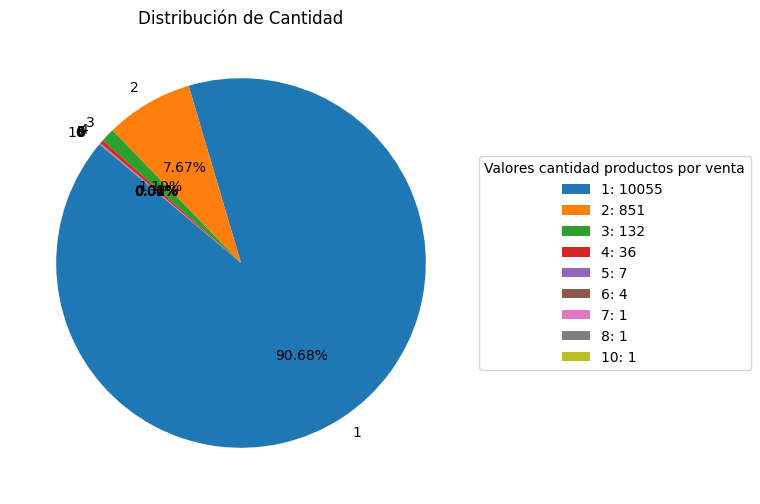

In [29]:
import matplotlib.pyplot as plt

# Filtrar valores no nulos y calcular frecuencia
cantidad_frecuencia = sales['CANTIDAD'].value_counts()

plt.figure(figsize=(6, 6))  # Ajustar tamaño del gráfico
wedges, texts, autotexts = plt.pie(
    cantidad_frecuencia, 
    labels=cantidad_frecuencia.index, 
    autopct='%2.2f%%', 
    startangle=140
)
leyenda = [f"{index}: {value} " for index, value in cantidad_frecuencia.items()]
plt.legend(
    wedges, 
    leyenda, 
    title="Valores cantidad productos por venta", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Distribución de Cantidad')
plt.show()



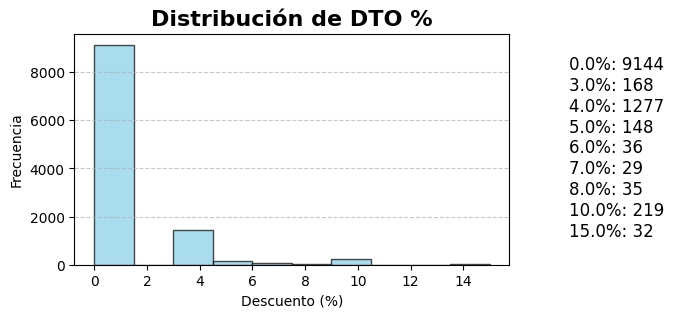

In [30]:
dto_frecuencia = sales['DTO %'].value_counts().sort_index()

plt.figure(figsize=(6, 3))
plt.hist(sales['DTO %'], bins=10, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Distribución de DTO %', fontsize=16, fontweight='bold')
plt.xlabel('Descuento (%)', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

frecuencias_texto = "\n".join([f"{index}%: {value}" for index, value in dto_frecuencia.items()])
plt.gcf().text(0.95, 0.5, frecuencias_texto, fontsize=12, verticalalignment='center')
plt.subplots_adjust(right=0.85)

plt.show()

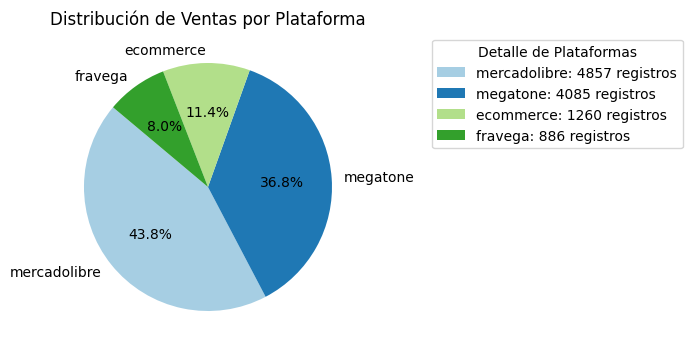

In [31]:
frecuencia_plataforma = sales['PLATAFORMA'].value_counts()

plt.figure(figsize=(4, 8))
plt.pie(
    frecuencia_plataforma,
    labels=frecuencia_plataforma.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title('Distribución de Ventas por Plataforma', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} registros" for index, value in frecuencia_plataforma.items()],
    title="Detalle de Plataformas",    
    loc="center left",
    bbox_to_anchor=(1.2, 0.8)  
)

plt.show()

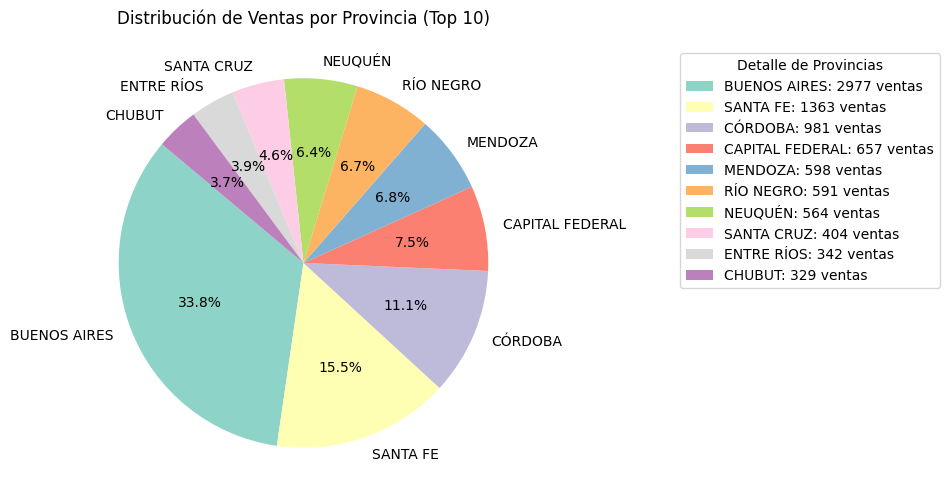

In [32]:
frecuencia_provincia = sales['PROVINCIA'].value_counts().head(10)

plt.figure(figsize=(6, 6))
plt.pie(
    frecuencia_provincia,
    labels=frecuencia_provincia.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title('Distribución de Ventas por Provincia (Top 10)', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} ventas" for index, value in frecuencia_provincia.items()],
    title="Detalle de Provincias",
    loc="center left", 
    bbox_to_anchor=(1.3, 0.7) 
)

plt.show()


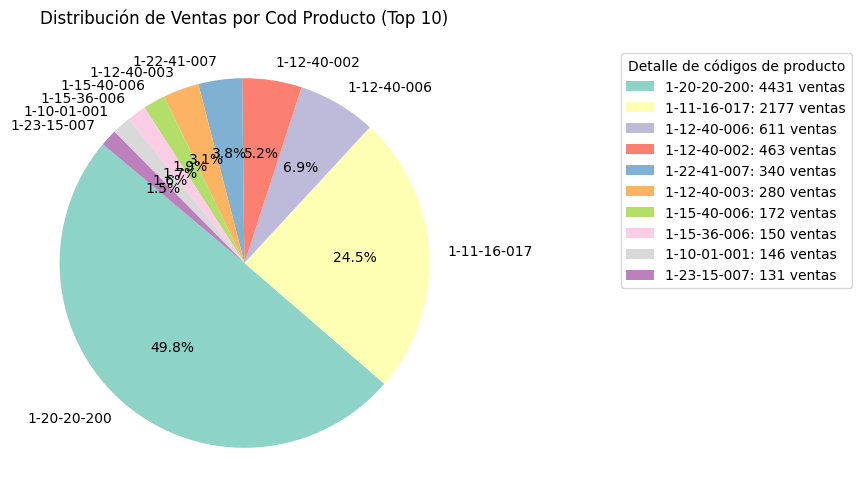

In [33]:
frecuencia_provincia = sales['COD. PRODUCTO'].value_counts().head(10)

plt.figure(figsize=(6, 6))
plt.pie(
    frecuencia_provincia,
    labels=frecuencia_provincia.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title('Distribución de Ventas por Cod Producto (Top 10)', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} ventas" for index, value in frecuencia_provincia.items()],
    title="Detalle de códigos de producto",
    loc="center left", 
    bbox_to_anchor=(1.3, 0.7) 
)

plt.show()

## Transformaciones Fecha Compra

In [34]:
# Convertir 'FECHA COMPRA' a datetime especificando el formato exacto
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], format='%d/%m/%Y')

In [35]:
# Crear columnas temporales
sales['AÑO'] = sales['FECHA COMPRA'].dt.year
sales['MES'] = sales['FECHA COMPRA'].dt.month
sales['SEMANA'] = sales['FECHA COMPRA'].dt.isocalendar().week
sales['DÍA'] = sales['FECHA COMPRA'].dt.day

sales.sample(10)

,FECHA COMPRA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD,AÑO,MES,SEMANA,DÍA
6050,2023-05-14,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,CÓRDOBA,Córdoba,mercadolibre,1,2023,5,19,14
10883,2023-05-08,1-11-02-002,COLCHÓN L. SUPER CONFORT TRADICIONAL 80CMX190CM,0.0,MENDOZA,Villa Nueva De Guaymallen,megatone,1,2023,5,19,8
1149,2021-08-03,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,LA RIOJA,La Rioja,ecommerce,1,2021,8,31,3
9829,2022-12-15,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,SALTA,IRUYA,megatone,1,2022,12,50,15
6007,2023-05-13,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,RÍO NEGRO,Río Colorado,mercadolibre,4,2023,5,19,13
8563,2022-06-19,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,SANTA FE,ROSARIO,megatone,1,2022,6,24,19
6467,2023-07-21,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,TUCUMÁN,Tafí Viejo,mercadolibre,1,2023,7,29,21
9648,2022-11-10,1-15-40-003,CONJUNTO L. ROMA TRADICIONAL 90CMX190CM,4.0,SANTA FE,ROSARIO,megatone,1,2022,11,45,10
9763,2022-11-29,1-10-02-001,ALMOHADAS L.PLACA 70CM,0.0,CHUBUT,RADA TILLY,megatone,2,2022,11,48,29
9553,2022-11-02,1-15-27-018,CONJUNTO L. GRANATE TRADICIONAL 180CMX200CM,4.0,CATAMARCA,SAN FERNANDO DEL VALLE DE CATAMARCA,megatone,1,2022,11,44,2


* Distribucion de ventas por mes

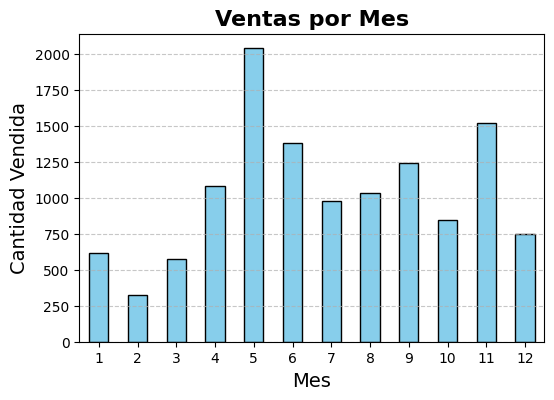

In [36]:
ventas_por_mes = sales.groupby('MES')['CANTIDAD'].sum()

plt.figure(figsize=(6, 4))
ventas_por_mes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Ventas por Mes', fontsize=16, fontweight='bold')
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



## Adapto el dataset para analizar tanto patrones semanales como mensuales. El objetivo es trabajar con la predicción por período de tiempo y agrupar las ventas por un intervalo de tiempo y producto

In [37]:
# Asegurar formato datetime
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], errors='coerce')

# Crear columnas de MES y AÑO
sales['MES'] = sales['FECHA COMPRA'].dt.month
sales['AÑO'] = sales['FECHA COMPRA'].dt.year  

# Agregar columna de EVENTO
sales['EVENTO'] = sales['MES'].apply(
    lambda x: 'Hot Sale' if x == 5 else ('CyberMonday' if x == 11 else 'Estandar')
)

# Agrupar por MES, AÑO y COD. PRODUCTO
sales = sales.groupby(['AÑO', 'MES', 'SEMANA', 'COD. PRODUCTO', 'PRODUCTO', 'PLATAFORMA', 'EVENTO', 'PROVINCIA', 'LOCALIDAD']).agg(
    CANTIDAD_TOTAL=('CANTIDAD', 'sum'),  # Cantidad total vendida en el mes
    DTO_PROMEDIO=('DTO %', 'mean')  # Promedio del descuento aplicado en el mes
).reset_index()


sales.sample(5)

,AÑO,MES,SEMANA,COD. PRODUCTO,PRODUCTO,PLATAFORMA,EVENTO,PROVINCIA,LOCALIDAD,CANTIDAD_TOTAL,DTO_PROMEDIO
9413,2023,9,36,1-12-40-002,COLCHÓN L. ROMA TRADICIONAL 80CMX190CM,megatone,Estandar,CÓRDOBA,BARRIO AMPLIACION AMERICA ANEXO,1,4.0
1392,2021,11,45,1-10-01-002,ALMOHADAS L.COPO 80CM,megatone,CyberMonday,RÍO NEGRO,ARROYO DE LA VENTANA,2,0.0
9310,2023,8,35,1-15-37-019,CONJUNTO L. VASARI TRADICIONAL 200CMX200CM,mercadolibre,Estandar,BUENOS AIRES,Máximo Paz,1,0.0
6042,2023,1,3,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,mercadolibre,Estandar,SANTA FE,San Martin de las Escobas,2,0.0
3631,2022,7,30,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,megatone,Estandar,ENTRE RÍOS,PARANA,1,0.0


In [38]:
sales.shape

(10145, 11)

### Tendencias de mi nuevo data set

#### Evolución de ventas mensuales generales. Se grafica la evolución de las ventas totales en todos los productos. 

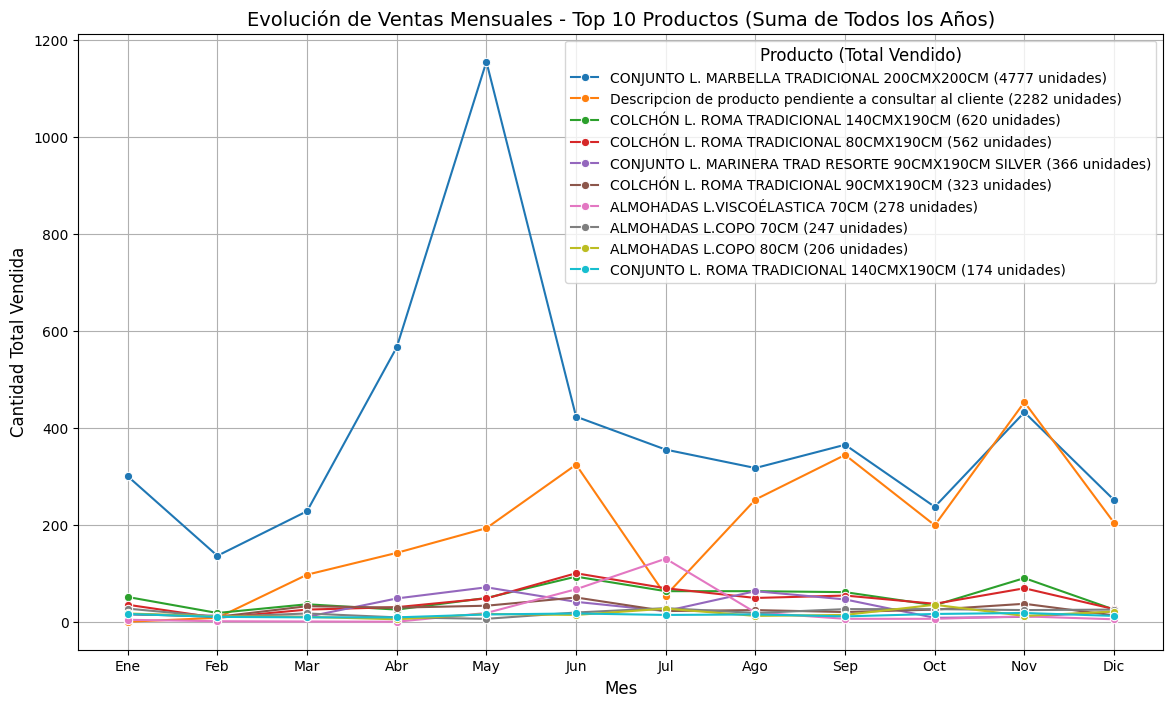

In [39]:
# Seleccionar los 10 productos más vendidos sumando todos los años
top_productos = sales.groupby("COD. PRODUCTO")["CANTIDAD_TOTAL"].sum().nlargest(10).index

# Filtrar dataset con solo estos productos y sumar las ventas por mes
ventas_top_productos = sales[sales["COD. PRODUCTO"].isin(top_productos)]

# Obtener el nombre del producto correspondiente a cada código
mapa_productos = ventas_top_productos[['COD. PRODUCTO', 'PRODUCTO']].drop_duplicates().set_index('COD. PRODUCTO')['PRODUCTO'].to_dict()

# Usar .loc[] para evitar la advertencia de "SettingWithCopyWarning"
ventas_top_productos.loc[:, 'PRODUCTO'] = ventas_top_productos['COD. PRODUCTO'].map(mapa_productos)

# Agrupar sumando ventas totales por mes sin diferenciar el año
ventas_top_productos = ventas_top_productos.groupby(['MES', 'PRODUCTO'])['CANTIDAD_TOTAL'].sum().reset_index()

# Ordenar los productos por cantidad total de ventas
total_ventas_por_producto = ventas_top_productos.groupby("PRODUCTO")["CANTIDAD_TOTAL"].sum().sort_values(ascending=False)
productos_ordenados = total_ventas_por_producto.index

# Crear el gráfico
plt.figure(figsize=(14,8))
sns.lineplot(data=ventas_top_productos, x="MES", y="CANTIDAD_TOTAL", hue="PRODUCTO", marker="o", palette="tab10", hue_order=productos_ordenados)

# Modificar etiquetas en la leyenda para incluir cantidad total vendida
handles, labels = plt.gca().get_legend_handles_labels()
nuevas_labels = [f"{prod} ({int(total_ventas_por_producto[prod])} unidades)" for prod in labels]
plt.legend(handles, nuevas_labels, title="Producto (Total Vendido)", fontsize=10, title_fontsize=12)

# Agregar etiquetas
plt.title("Evolución de Ventas Mensuales - Top 10 Productos (Suma de Todos los Años)", fontsize=14)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Cantidad Total Vendida", fontsize=12)
plt.xticks(range(1,13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.grid()

# Mostrar gráfico
plt.show()




## Matriz de correlación

In [40]:
#Preparo el dataset para realizar la matriz de correlación
sales = pd.get_dummies(sales, columns=['PLATAFORMA', 'EVENTO'], drop_first=False)
sales.columns = sales.columns.str.replace('PLATAFORMA_', '').str.replace('EVENTO_', '')

# Convertir todas las columnas booleanas a enteros (1 para True, 0 para False)
sales[['ecommerce', 'fravega', 'megatone', 'mercadolibre', 'CyberMonday', 'Estandar', 'Hot Sale']] = \
sales[['ecommerce', 'fravega', 'megatone', 'mercadolibre', 'CyberMonday', 'Estandar', 'Hot Sale']].astype(int)




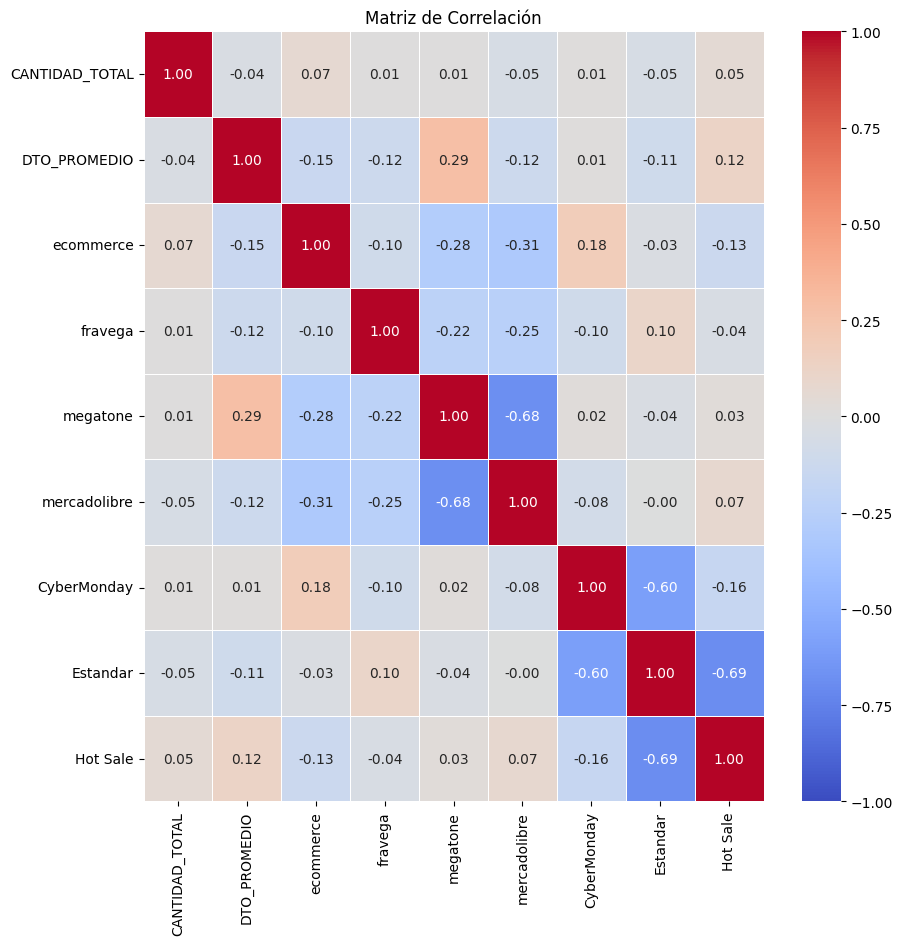

In [41]:
# Seleccionamos las variables numéricas (esto incluye las nuevas columnas de One Hot Encoding)
variables_numericas_ampliadas = sales.select_dtypes(include=['float64', 'int64'])

correlacion_ampliada = variables_numericas_ampliadas.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlacion_ampliada, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Agregar título y etiquetas
plt.title("Matriz de Correlación", fontsize=12)
plt.show()




Podemos observar que: 

CANTIDAD_TOTAL:
- No parece haber una relación significativa entre la cantidad vendida y el descuento promedio aplicado, lo cual es interesante. Esto podría sugerir que el descuento no es un factor determinante para el volumen de ventas, o bien que otras variables más relevantes influyen en las ventas.
- La CANTIDAD_TOTAL está levemente correlacionada con las plataformas. Esto podría indicar que ciertas plataformas (como ecommerce y mercadolibre) podrían tener una mayor cantidad de ventas.

DTO_PROMEDIO:
- Hay una pequeña correlación positiva (0.29) entre el descuento promedio y megatone, lo que sugiere que cuando los productos de megatone tienen mayores descuentos, las ventas aumentan, aunque no sea una relación muy fuerte.
- Hay una relación negativa bastante fuerte (-0.68) entre el descuento promedio y mercadolibre. Esto podría implicar que cuando los descuentos en mercadolibre son mayores, las ventas no aumentan de manera tan significativa, o los productos con mayores descuentos pueden tener menos demanda en esta plataforma.
  
Plataformas (ecommerce, fravega, megatone, mercadolibre):

- Megatone podría estar más orientado a una plataforma distinta, mientras que mercadolibre y ecommerce tienen una relación diferente.
- Fravega tiene una correlación muy baja con las demás variables (casi todos valores están cerca de 0), lo que sugiere que las ventas en fravega no están muy relacionadas con las demás plataformas.
  
Eventos (CyberMonday, Hot Sale, Estandar):

- CyberMonday y Hot Sale pueden tener un efecto muy particular sobre el comportamiento de las ventas, posiblemente en diferentes plataformas, con menos efecto sobre otras.
- Ventas en épocas que no sean eventos también muestra una correlación negativa significativa con CANTIDAD_TOTAL, lo que sugiere que durante los meses "normales", las ventas son más bajas que durante eventos como Hot Sale o CyberMonday


# Hipótesis sobre los datos

## Hipotesis 1: 

#### Comparación de ventas promedio en meses normales vs. eventos

In [42]:
# Crear una columna para categorizar los meses
ventas_por_evento = sales.assign(
    TIPO_MES = sales['MES'].apply(
        lambda x: 'Hot Sale' if x == 5 else ('CyberMonday' if x == 11 else 'Mes Normal')
    )
)

# Agrupar por tipo de mes y calcular ventas promedio
ventas_por_evento = ventas_por_evento.groupby("TIPO_MES")["CANTIDAD_TOTAL"].mean().reset_index()

# Mostrar la tabla en el notebook
from IPython.display import display
display(ventas_por_evento)


,TIPO_MES,CANTIDAD_TOTAL
0,CyberMonday,1.243464
1,Hot Sale,1.298279
2,Mes Normal,1.199946


##### Los meses con Hot Sale y CyberMonday tienen ventas superiores a los meses normales.

* En meses normales, se venden en promedio 11.22 unidades de un producto por mes.
* Durante CyberMonday, este número aumenta a 13.83.
* En Hot Sale, la cantidad promedio sube aún más a 17.26.
  
##### Hot Sale parece generar un mayor impacto en las ventas que CyberMonday.

* El aumento en Hot Sale es mayor que en CyberMonday.
* Esto podría deberse a que mayo (Hot Sale) tiene más días promocionales, o a que hay una mayor demanda en ese momento del año

##### Calculamos el porcentaje de aumento en ventas en estos eventos:

* Hot Sale vs. Mes Normal:
(17.26 − 11.22 / 11.22) × 100 = 53.87 % de aumento

* CyberMonday vs. Mes Normal:
(13.83 − 11.22 / 11.22) × 100 = 23.26 % de aumento

#### Conclusión
✔ Confirmamos la hipótesis: Hot Sale y CyberMonday aumentan significativamente las ventas.

✔ El impacto es mayor en Hot Sale (≈ 54% más ventas), que en CyberMonday (≈ 23% más ventas).

## Hipotesis 2: 

#### Los meses con mayor descuento promedio tienen más ventas
Se plantea ver si en un mes hay un mayor descuento promedio la cantidad de productos vendidos es mayor

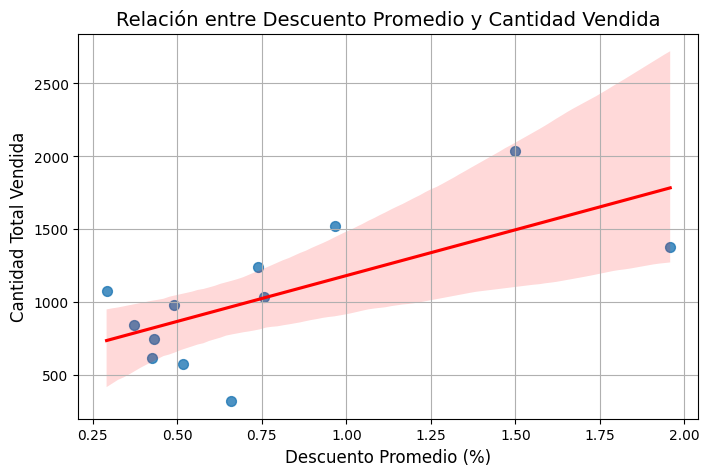

In [43]:
# Agrupar ventas y descuentos promedio por mes
ventas_vs_descuento = sales.groupby("MES").agg(
    CANTIDAD_TOTAL=('CANTIDAD_TOTAL', 'sum'),
    DTO_PROMEDIO=('DTO_PROMEDIO', 'mean')
).reset_index()

# Crear gráfico de dispersión con regresión
plt.figure(figsize=(8,5))
sns.regplot(x=ventas_vs_descuento["DTO_PROMEDIO"], y=ventas_vs_descuento["CANTIDAD_TOTAL"], scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Agregar etiquetas
plt.title("Relación entre Descuento Promedio y Cantidad Vendida", fontsize=14)
plt.xlabel("Descuento Promedio (%)", fontsize=12)
plt.ylabel("Cantidad Total Vendida", fontsize=12)
plt.grid()

# Mostrar gráfico
plt.show()

##### Relación positiva entre descuento promedio y cantidad vendida:
* La línea de tendencia (roja) indica que a medida que el descuento promedio aumenta, también lo hace la cantidad total vendida.
* Esto sugiere que los descuentos tienen un efecto positivo en las ventas totales.

##### Dispersión moderada:
* Aunque hay una relación positiva, no todos los puntos se encuentran cercanos a la línea de tendencia.
* Esto puede indicar que otros factores (como el tipo de producto o eventos como Hot Sale y CyberMonday) también influyen en la cantidad vendida.

##### Rango del descuento promedio:
* Los descuentos promedio oscilan entre 0.4% y 1.8%.
* Dentro de este rango, los meses con descuentos más altos parecen tener ventas significativamente mayores.

##### Meses con bajo descuento y ventas bajas:
* Algunos puntos con descuentos bajos (ej.: <1%) muestran menos ventas totales, lo que refuerza la hipótesis de que los descuentos pueden impulsar las compras.

#### Conclusión
✔ La hipótesis es consistente con los datos: Los meses con mayor descuento promedio tienden a tener mayores ventas totales.

✔ Descuento como factor clave: Este hallazgo sugiere que el descuento promedio es una variable importante que debería incluirse en el modelo de predicción de ventas.


# Modelado

### Elección de la métrica de performance a utilizar para evaluar los modelos y fundamentación.

Dado que se está trabajando en un modelo de regresión para predecir la cantidad de productos vendidos, productos vendidos, la métrica elegida debe reflejar qué tan bien el modelo está prediciendo valores continuos. Para ello, se utilizará la **Raíz del Error Cuadrático Medio (RMSE - Root Mean Squared Error)**.

Se ha optado por esta métrica porque proporciona una medida clara y directa de la diferencia promedio entre las predicciones y los valores reales, lo cual es crucial en problemas de predicción de ventas. La principal ventaja del RMSE sobre el MSE es que se calcula tomando la raíz cuadrada del MSE, lo que resulta en una métrica que tiene las mismas unidades que la variable objetivo (es decir, la cantidad de productos vendidos). Esto lo hace más interpretable en el contexto del negocio.

Por otro lado, el MSE tiende a dar valores más grandes debido al efecto cuadrático de las diferencias, lo que puede resultar en una penalización exagerada de los errores grandes. Al tomar la raíz cuadrada, el RMSE proporciona una medida que mantiene la escala de los datos, haciendo más fácil de entender su impacto en las predicciones de ventas.

### Próximo paso será entrenar y evaluar al menos 3 algoritmos de machine learning distintos, realizando una exploración de hiper-parámetros mediante una búsqueda en grilla. Evaluar el comportamiento de cada modelo con los que mejores resultados ofrecen aportando conclusiones respecto a dicha comparación.

In [44]:
# Asegurarse de que las columnas 'AÑO' y 'MES' sean numéricas (enteros)
sales['AÑO'] = pd.to_numeric(sales['AÑO'], errors='coerce')
sales['MES'] = pd.to_numeric(sales['MES'], errors='coerce')

# Crear una columna de fecha combinando AÑO, MES y un día fijo (el primer día del mes) y Formatear la fecha a DD-MM-YYYY
sales['FECHA_COMPRA'] = pd.to_datetime(sales['AÑO'].astype(str) + '-' + sales['MES'].astype(str) + '-1', format='%Y-%m-%d')
sales['FECHA_COMPRA'] = sales['FECHA_COMPRA'].dt.strftime('%d-%m-%Y')

# Ordenar el dataset por la nueva columna 'FECHA_COMPRA' (ascendente)
sales = sales.sort_values(by='FECHA_COMPRA', ascending=True)

# Verificar las primeras filas después de ordenar
sales.head()


,AÑO,MES,SEMANA,COD. PRODUCTO,PRODUCTO,PROVINCIA,LOCALIDAD,CANTIDAD_TOTAL,DTO_PROMEDIO,ecommerce,fravega,megatone,mercadolibre,CyberMonday,Estandar,Hot Sale,FECHA_COMPRA
1870,2022,1,2,1-11-06-005,COLCHÓN L. RELAX 22 TRADICIONAL 130CMX190CM,SANTA FE,ROSARIO,1,0.0,0,0,1,0,0,1,0,01-01-2022
1918,2022,1,4,1-10-01-001,ALMOHADAS L.COPO 70CM,BUENOS AIRES,TRES ARROLLOS,2,0.0,0,0,1,0,0,1,0,01-01-2022
1917,2022,1,4,1-10-01-001,ALMOHADAS L.COPO 70CM,BUENOS AIRES,TANDIL,2,0.0,0,0,1,0,0,1,0,01-01-2022
1916,2022,1,3,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,SANTA FE,Rosario,1,0.0,0,0,0,1,0,1,0,01-01-2022
1915,2022,1,3,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,BUENOS AIRES,Cañuelas,2,0.0,0,0,0,1,0,1,0,01-01-2022


In [45]:
#Elimino los dos registros outliers con data (seguramente mal cargada) del 2002
sales = sales[sales['AÑO'] != 2002]
sales = sales.drop(columns=[ "PRODUCTO","PROVINCIA", "LOCALIDAD"])

In [46]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(sales, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape


((6085, 14), (2029, 14), (2029, 14))

In [52]:
# Eliminar registros con valores NaN en la columna 'CANTIDAD_TOTAL' de manera persistente
train = train.dropna(subset=['CANTIDAD_TOTAL'])
validation = validation.dropna(subset=['CANTIDAD_TOTAL'])
test = test.dropna(subset=['CANTIDAD_TOTAL'])

# Asegúrate de que las columnas de entrada no tengan valores NaN en el DataFrame
X_train = train.drop(columns=['CANTIDAD_TOTAL'])  # Características de entrenamiento
y_train = train['CANTIDAD_TOTAL']  # Target de entrenamiento

X_test = test.drop(columns=['CANTIDAD_TOTAL'])  # Características de test
y_test = test['CANTIDAD_TOTAL']  # Target de test

mapper = DataFrameMapper([
    # Columnas numéricas (como AÑO, MES, SEMANA, etc.)
    (['AÑO', 'MES', 'SEMANA', 'DTO_PROMEDIO'], [StandardScaler()]),
    # Columnas de eventos y plataformas (por ejemplo, ecommerce, fravega, etc.)
    (['ecommerce', 'fravega', 'megatone', 'mercadolibre', 'CyberMonday', 'Estandar', 'Hot Sale'], [StandardScaler()]),
])

# Ajustar la transformación en X_train
X_train_transformed = mapper.fit_transform(X_train)

# Aplicar la transformación solo a X_test (sin 'fit', solo 'transform')
X_test_transformed = mapper.transform(X_test)

# Verificar que las columnas estén alineadas correctamente
print(X_train_transformed.shape)  # Verifica el número de columnas
print(X_test_transformed.shape)   # Verifica que las columnas de test coincidan con train



(6085, 11)
(2029, 11)


C:\Users\bosch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


In [47]:
#mapper = DataFrameMapper([
    # Columnas numéricas
#    (['AÑO', 'MES', 'SEMANA', 'CANTIDAD_TOTAL', 'DTO_PROMEDIO'], [StandardScaler()]),
    # Columnas de eventos y plataformas (sin escalarlas, solo OneHotEncoder)
#    (['ecommerce', 'fravega', 'megatone', 'mercadolibre', 'CyberMonday', 'Estandar', 'Hot Sale'], [OneHotEncoder()])
#])

In [53]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_rmse=True):
    if title:
        display(title)
        
    final_metrics = {
        'RMSE': [],        
    }
    
    for i, data_set in enumerate(set_names):
        assert data_set in ['train', 'validation', 'test']
        
        # Obtén los datos del conjunto (train, validation, test)
        set_data = globals()[data_set]
        
        # Separar características y variable target
        X = set_data.drop(columns=['CANTIDAD_TOTAL'])  # Características
        y = set_data['CANTIDAD_TOTAL']  # Target
        
        # Realizar predicciones con el modelo
        y_pred = model.predict(X)
        
        # Calcular RMSE
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        final_metrics['RMSE'].append(rmse)
        
        # Mostrar métricas si es necesario
        print(f"Evaluación en el conjunto {data_set}:")
        print(f"  - RMSE: {rmse}")
        
    # Mostrar un resumen de las métricas
    display(pd.DataFrame(final_metrics, index=set_names))


In [57]:
# Verifica si las columnas coinciden entre X_train y X_test
print("Columnas en X_train:", X_train_transformed.shape[1])
print("Columnas en X_test:", X_test_transformed.shape[1])

# Asegúrate de que las columnas en ambos conjuntos estén alineadas
assert X_train_transformed.shape[1] == X_test_transformed.shape[1], "El número de columnas no coincide entre train y test."


Columnas en X_train: 11
Columnas en X_test: 11


### Entrenamiento modelo Regresion Lineal

In [65]:
# Definir el modelo de regresión lineal
lr_clasif = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
lr_clasif.fit(X_train_transformed, y_train)

# Realizar las predicciones en el conjunto de test
y_pred_test = lr_clasif.predict(X_test_transformed)

# Calcular el RMSE en test
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Imprimir el RMSE en el conjunto de test
print(f"RMSE en test: {rmse_test}")

RMSE en test: 0.586223927162933


### Entrenamiento modelo RIDGE

In [80]:
ridge_model = Ridge()

# Definir los hiperparámetros a buscar
parameters = {
    'alpha': [0.01, 0.1, 1, 10, 50, 100],  # Hiperparámetro de regularización
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']  # Métodos de optimización
}

# Realizar GridSearchCV para encontrar los mejores hiperparámetros
grid_search_ridge = GridSearchCV(estimator=ridge_model, param_grid=parameters, cv=2, scoring='neg_mean_squared_error', verbose=1)

# Ajuste y entrenamiento
grid_search_ridge.fit(X_train_transformed, y_train)

# Obtener el mejor modelo con los mejores parámetros
best_ridge_model = grid_search_ridge.best_estimator_

# Ver los mejores parámetros encontrados
print("Mejores parámetros Ridge:", grid_search_ridge.best_params_)

# Predicción en el conjunto de test
y_pred_ridge = best_ridge_model.predict(X_test_transformed)

# Calcular el RMSE en test
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# Imprimir el RMSE en el conjunto de test
print(f"RMSE en test (Ridge): {rmse_ridge}")

Fitting 2 folds for each of 30 candidates, totalling 60 fits
Mejores parámetros Ridge: {'alpha': 100, 'solver': 'saga'}
RMSE en test (Ridge): 0.5862615065381273


### Entrenamiento modelo LASSO

In [68]:
lasso_model = Lasso()

# Definir los hiperparámetros a buscar
parameters = {
    'alpha': [0.01, 0.1, 1, 10, 100],  # Hiperparámetro de regularización
}

# Realizar GridSearchCV para encontrar los mejores hiperparámetros
grid_search_lasso = GridSearchCV(estimator=lasso_model, param_grid=parameters, cv=2, scoring='neg_mean_squared_error', verbose=1)

# Ajuste y entrenamiento
grid_search_lasso.fit(X_train_transformed, y_train)

# Obtener el mejor modelo con los mejores parámetros
best_lasso_model = grid_search_lasso.best_estimator_

# Ver los mejores parámetros encontrados
print("Mejores parámetros Lasso:", grid_search_lasso.best_params_)

# Predicción en el conjunto de test
y_pred_lasso = best_lasso_model.predict(X_test_transformed)

# Calcular el RMSE en test
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# Imprimir el RMSE en el conjunto de test
print(f"RMSE en test (Lasso): {rmse_lasso}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Mejores parámetros Lasso: {'alpha': 0.01}
RMSE en test (Lasso): 0.5875025111409704
